# The Push for Pay Transparency
In today’s workplace, Diversity, Equity, and Inclusion (DEI) go beyond policies; they’re about **ensuring everyone is treated and compensated fairly, regardless of gender, race, or other "protected" characteristics**. A key measure of fair compensation is the gender pay gap (GPG), which identifies differences in average pay between men and women. **With recent directives like the upcoming EU pay transparency regulation, companies are increasingly required to disclose pay data**, which underscores the need for accurate and meaningful GPG reporting.

Many companies are now reporting their GPG in annual reports to the public. As such, accurately **estimating the GPG is paramount, not only for compliance but also to maintain a reputable employer brand**. Traditionally, this analysis might have been handled by finance teams, but as the scope of People Analytics grows, HR data experts are stepping into the field of GPG reporting. However, **calculating and interpreting the GPG is complex**, involving decisions on what factors to include or adjust for, to paint an accurate picture.

In this post, I’ll **break down key metrics** that help HR teams assess the GPG and highlight how certain analytical choices can impact the results. Plus, I’ll **share some code** to make implementing these calculations straightforward for your team.

# Key Metrics for Gender Pay Gap Reporting

There are two main metrics often used to report on gender pay gaps: the Unadjusted Gender Pay Gap (UGPG) and the Adjusted Gender Pay Gap (AGPG).

- **Unadjusted Gender Pay Gap (UGPG)**: This is the difference in average pay between male and female employees, presented as a percentage of average male pay. The UGPG gives a high-level view of pay disparities without accounting for factors like job type or experience.

- **Adjusted Gender Pay Gap (AGPG)**: This metric is a deeper analysis that controls for factors like job role, experience, and other structural differences, allowing for a more direct comparison of pay between men and women in similar roles.

The AGPG can vary significantly based on the adjustments made, and determining what qualifies as “comparable positions” is key. Questions like, “What defines a comparable role?” and “Which factors should be adjusted for?” are critical for companies to consider when interpreting their GPG results. While the UGPG is more explicitly defined by [EU directives]('('https://eur-lex.europa.eu/legal-content/EN/TXT/PDF/?uri=CELEX:32023L0970')'), the AGPG lacks a standardized calculation method, often requiring customized models based on the specific organization.

# A concrete GPG analysis example

## The Data
For this post, I will be using the [Glassdoor Gender Pay Gap data from Kaggle]('https://www.kaggle.com/datasets/nilimajauhari/glassdoor-analyze-gender-pay-gap').
This dataset includes 1,000 records of individual salaries, bonuses, job titles, and other attributes relevant to compensation.

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from causalinference import CausalModel
from sklearn.neighbors import NearestNeighbors
import statsmodels.formula.api as smf
from scipy.stats import t
import kagglehub
from statsmodels.stats.oaxaca import OaxacaBlinder



# Download latest version
path = kagglehub.dataset_download("nilimajauhari/glassdoor-analyze-gender-pay-gap")


In [23]:
# Step 1: Load data
df = pd.read_csv(path + '/Glassdoor Gender Pay Gap.csv')
print(df.head())
print(f"Number of rows: {df.shape[0]}")
# Step 2: Data Cleaning
df_clean = df.dropna()  # Remove missing data

              JobTitle  Gender  Age  PerfEval Education            Dept  \
0     Graphic Designer  Female   18         5   College      Operations   
1    Software Engineer    Male   21         5   College      Management   
2  Warehouse Associate  Female   19         4       PhD  Administration   
3    Software Engineer    Male   20         5   Masters           Sales   
4     Graphic Designer    Male   26         5   Masters     Engineering   

   Seniority  BasePay  Bonus  
0          2    42363   9938  
1          5   108476  11128  
2          5    90208   9268  
3          4   108080  10154  
4          5    99464   9319  
Number of rows: 1000


## Data Exploration
Before calculating the UGPG and AGPG, it is crucial to examine characteristics such as age, performance, seniority, and education across genders. This initial exploration can reveal structural differences between groups and highlight areas that may need adjustment.

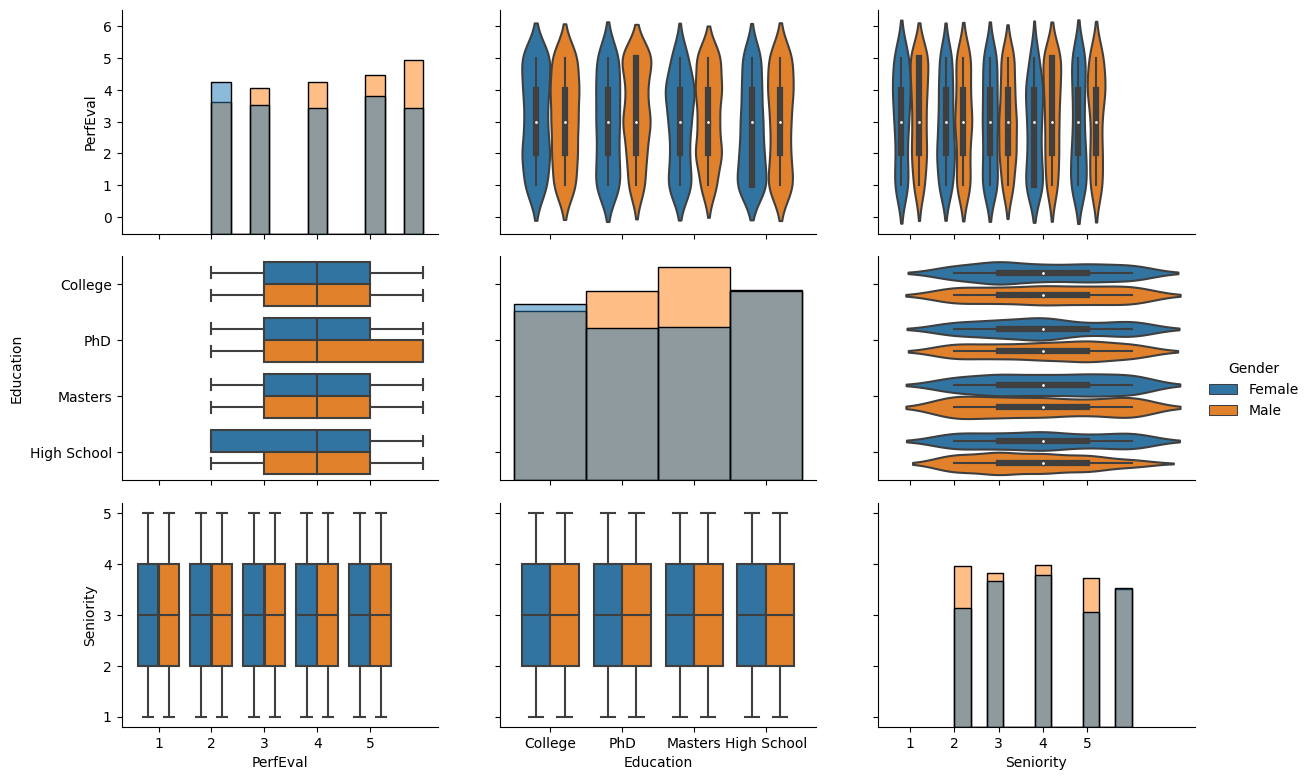

In [24]:
# Define PairGrid with customization
g = sns.PairGrid(df_clean, hue='Gender', vars = ['PerfEval', 'Education', 'Seniority'])
# Set the plot size (enlarge it)
g.fig.set_size_inches(12, 8)
# Define plot types for the grid
g.map_upper(sns.violinplot)
g.map_lower(sns.boxplot)  # Boxplot for numerical-categorical relationships
g.map_diag(sns.histplot, kde=False)  # Histograms with KDE for diagonal

g.add_legend()
plt.show()

In this plot, we see distributions and joint relationships between age, performance evaluation, seniority, and education. There are apparent differences across genders, suggesting that groups may not be fully comparable in all characteristics. We’ll address this issue further in the analysis.

# Unadjusted Gender Pay Gap

The first step in analyzing the GPG would be calculating the average difference in pay between man and women, also called the Unadjusted Gender Pay gap.
In our case we will be calculating this metric following the definition above which is 

$$
\text{UGPG} = \frac{\text{Avg. male earnings} - \text{Avg. female earnings}}{\text{Avg. male earnings}} \times 100\%
$$

In [25]:
# Step 4: Unadjusted Gender Pay Gap
avg_pay_men = df_clean[df_clean['Gender'] == 'Male']['BasePay'].mean()
avg_pay_women = df_clean[df_clean['Gender'] == 'Female']['BasePay'].mean()
ugpg = round(((avg_pay_men - avg_pay_women) / avg_pay_men) * 100, 2)
print(f"The Unadjusted Gender Pay Gap is {ugpg}%")

The Unadjusted Gender Pay Gap is 8.65%


the UGPG here is -8.65%, meaning women earn 8.65% less than men, on average. However, this simple metric doesn’t account for other pay-determining factors, such as job title or experience. **The UGPG is a broad measure, which is why many companies also report AGPG**.


# Adjusted GPG

The AGPG can be seen as a refined UGPG, where individual characteristics are taken into account when comparing men and women differences in salary.


## Linear regression
Linear regression is a simple yet effective method to calculate the AGPG. For our data we consider different variables that we expect to influence pay such as education, seniority, and performance, alongside gender. 


In [26]:
# Step 5: Adjusted Gender Pay Gap using Linear Regression
df_clean['BasePay_log'] = np.log(df_clean['BasePay'])  # Log transform salary
df_clean['Gender_fac'] = df_clean['Gender'].apply(lambda x: 1 if x == "Female" else 0)  # Dummy variable

# Define the regression formula
formula = 'BasePay_log ~ Age + PerfEval + Education + Seniority + Dept + JobTitle + Gender_fac'
model = smf.ols(formula=formula, data=df_clean).fit()

# Extract Adjusted Gender Pay Gap
agpg_lm = round((np.exp(model.params['Gender_fac']) - 1) * 100, 2)
print(f"Adjusted GPG (Linear Regression): {agpg_lm}%")

# Extract confidence intervals
ci_lm = (np.exp(model.conf_int().loc['Gender_fac']) - 1) * 100

Adjusted GPG (Linear Regression): -1.05%
95% Confidence Interval for Linear Regression: 0   -2.775696
1    0.700098
Name: Gender_fac, dtype: float64


Here, based on the linear regression results women are paid -1.05% less than men on average, after adjusting for individual characteristics. However, this linear model assumes that the impact of factors like seniority is identical for men and women, which might not capture true gender-specific effects. 


## The Oaxaca-Blinder Decomposition
An approach that overcomes this linear regression limitation is the Oaxaca-Blinder Decomposition, which is statistical method that decomposes pay differences into explainable factors (differences in education or experience) and unexplainable factors (someone's gender). Oaxaca-blinder fits different regression for men and women, thus allowing for gender-specific relationships between individual characteristics and pay.


In [32]:
# Ensure Gender is binary numeric
df_clean['Gender_fac'] = df_clean['Gender'].map({'Male': 0, 'Female': 1})

# Log-transform BasePay
df_clean['BasePay_log'] = np.log(df_clean['BasePay'])

# Define dependent variable (log-transformed pay) and independent variables
y = df_clean['BasePay_log']  # Dependent variable
X = df_clean[['Gender', 'Age', 'PerfEval', 'Education', 'Seniority', 'Dept', 'JobTitle']]  # Independent variables

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Perform the Oaxaca-Blinder decomposition
oaxaca = OaxacaBlinder(y, X, 'Gender_Male', hasconst=False)  # Use binary group variable
un,exp,oaxacagap = oaxaca.two_fold(std = True, n = 10, conf = .95).params
print(f"Adjusted GPG (Oaxaca-Blinder Decomposition): {oaxacagap}%")

Adjusted GPG (Oaxaca-Blinder Decomposition): 0.09531562176297825%


The Oaxaca-blinder results show that the AGPG is -0.86%, indicating that women earn, on average, 0.86% less than men. This model overcomes the linear regression limitation by allowing gender-specific relationships with pay.

An issue that is often overlooked by the Oaxaca-Blinder is that of group comparability. For instance, we coud have men in their early thirties with a specific job function (e.g., sales associate) and seniority but not women counterparts, and vice versa. This is a common situation since women may tend to concentrate in certain occupations for which specific skills are more likely to be found, whereas men may concentrate in other occupations [(England et al. 2007)]('https://nyuscholars.nyu.edu/en/publications/does-bad-pay-cause-occupations-to-feminize-does-feminization-redu').  In the Oaxaca-blinder model there are no restrictions imposed on estimating earnings for male and female with comparable characteristics [(Ñopo, 2004)]('https://www.iza.org/publications/dp/981/matching-as-a-tool-to-decompose-wage-g'). This issue is also known as "common support" issue. 

## Matched Regression
Matching addresses common support issues by pairing individuals with similar characteristics across gender groups, ensuring comparability.

Here, we use nearest neighbor matching to keep all observations in our small dataset while ensuring that each observation finds the closest comparable counterpart.

In [33]:
# Ensure data is clean and numeric
df_clean = df_clean.dropna(subset=['Age', 'PerfEval', 'Education', 'Seniority', 'Dept', 'JobTitle', 'Gender_fac', 'BasePay_log'])
df_clean['Gender_fac'] = df_clean['Gender'].map({'Male': 0, 'Female': 1}).astype(int)

# One-hot encode categorical variables
covariates = pd.get_dummies(df_clean[['Age', 'PerfEval', 'Education', 'Seniority', 'Dept', 'JobTitle']], drop_first=True)
treatment = df_clean['Gender_fac']
outcome = df_clean['BasePay_log']

# Ensure alignment of arrays
print(covariates.shape, treatment.shape, outcome.shape)

# Perform matching
causal = CausalModel(
    Y=outcome.values,
    D=treatment.values,
    X=covariates.values
)
causal.est_via_matching()

# Extract the treatment effect
agpg_matching = (np.exp(causal.estimates['matching']['ate'])-1)*100
print(f"Adjusted GPG (Matching): {agpg_matching}%")


(1000, 19) (1000,) (1000,)
Adjusted GPG (Matching): -1.9362624830769226%


The matched approach results in an AGPG of -2.29%. This suggests that when controlling for comparable characteristics, women earn 2.29% less than men on average. Matching mitigates bias from non-comparable characteristics, offering an improved comparison between genders.


## Comparing the results 

Last but not least, one aspect often underlooked is that of confidence around the AGPG estimates. While it may be appealing for companies to report only point estimates, it should be essential to consider the statistical significance of these estimates in addition to the practical significance. That is, how certain can we be that the estimated AGPG actually differs from 0 (i.e., no gender pay gap)?

While for linear regression it is straightforward to obtain confidence intervals, for matched regression and Oaxaca-Blinder Decomposition calculating the AGPG estimate confidence intervals it is not straightforward. Below we use bootstrap to calculate them. 

In [34]:
# Number of bootstrap samples
n_bootstraps = 300
alpha = 0.05  # For 95% CI

# Initialize list to store bootstrap results
oaxaca_bootstrap_results = []

# Bootstrapping loop
for _ in tqdm(range(n_bootstraps), desc="Bootstrapping Oaxaca-Blinder"):
    # Resample the data with replacement
    df_resampled = df_clean.sample(n=len(df_clean), replace=True)

    # Recompute y and X for resampled data
    y_resampled = df_resampled['BasePay_log']
    X_resampled = pd.get_dummies(df_resampled[['Gender', 'Age', 'PerfEval', 'Education', 'Seniority', 'Dept', 'JobTitle']], drop_first=True)

    # Perform the Oaxaca-Blinder decomposition
    oaxaca = OaxacaBlinder(y_resampled, X_resampled, 'Gender_Male', hasconst=False)
    result = oaxaca.two_fold()
    
    # Extract unexplained gap and append to results
    un,exp,gap = oaxaca.two_fold().params
    oaxaca_bootstrap_results.append(gap*-1)

# Calculate confidence intervals for the unexplained gap
oaxaca_lower = np.percentile(oaxaca_bootstrap_results, alpha / 2 * 100)
oaxaca_upper = np.percentile(oaxaca_bootstrap_results, (1 - alpha / 2) * 100)

print(f"Oaxaca-Blinder unexplained gap CI: [{oaxaca_lower:.4f}, {oaxaca_upper:.4f}]")

Bootstrapping Oaxaca-Blinder: 100%|██████████████████████████████████████████████████████████████████| 300/300 [00:18<00:00, 15.96it/s]

Oaxaca-Blinder unexplained gap CI: [-0.1274, -0.0581]


In [35]:
# Initialize list to store bootstrap results
matching_bootstrap_results = []

# Bootstrapping loop
for _ in tqdm(range(n_bootstraps), desc="Bootstrapping Matching"):
    # Resample the data with replacement
    df_resampled = df_clean.sample(n=len(df_clean), replace=True)

    # Recompute covariates, treatment, and outcome for resampled data
    covariates_resampled = pd.get_dummies(df_resampled[['Age', 'PerfEval', 'Education', 'Seniority', 'Dept', 'JobTitle']], drop_first=True)
    treatment_resampled = df_resampled['Gender_fac']
    outcome_resampled = df_resampled['BasePay_log']
    
    # Perform matching using your code
    causal = CausalModel(
        Y=outcome_resampled.values,
        D=treatment_resampled.values,
        X=covariates_resampled.values,
    )
    causal.est_via_matching()

    # Extract ATE and append to results
    matching_effect = np.exp(causal.estimates['matching']['ate']) - 1
    matching_bootstrap_results.append(matching_effect * 100)

# Calculate confidence intervals for the matching effect
matching_lower = np.percentile(matching_bootstrap_results, alpha / 2 * 100)
matching_upper = np.percentile(matching_bootstrap_results, (1 - alpha / 2) * 100)

print(f"Matching CI: [{matching_lower:.2f}%, {matching_upper:.2f}%]")


Bootstrapping Matching: 100%|████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 29.43it/s]

Matching CI: [-5.03%, 0.65%]


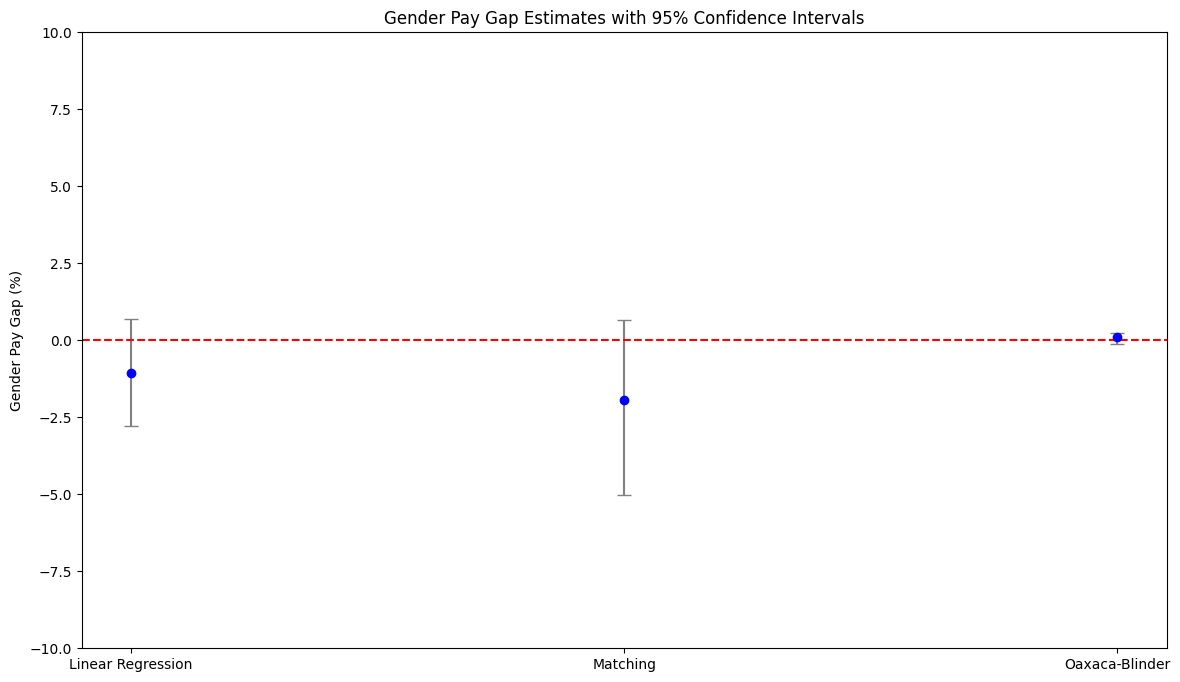

In [36]:
# Step 8: Comparing Results
methods = ["Linear Regression", "Matching", "Oaxaca-Blinder"]
estimates = [agpg_lm, agpg_matching, oxacagap]
ci_lowers = [ci_lm[0], matching_lower, oaxaca_lower]  # Add proper CI for matching and Oaxaca if available
ci_uppers = [ci_lm[1], matching_upper, oaxaca_upper]

# Calculate the lower and upper errors dynamically
lower_errors = [abs(estimate - ci_lower) if estimate > ci_lower else abs(ci_lower - estimate) for estimate, ci_lower in zip(estimates, ci_lowers)]
upper_errors = [abs(ci_upper - estimate) if estimate < ci_upper else abs(estimate - ci_upper) for estimate, ci_upper in zip(estimates, ci_uppers)]

# Combine lower and upper errors
errors = [lower_errors, upper_errors]

# Plotting with error bars
plt.figure(figsize=(14, 8))
plt.errorbar(methods, estimates, yerr=errors, fmt='o', color='blue', ecolor='gray', capsize=5)
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0
# Customize the y-axis range
plt.ylim(-10, 10)  # Set y-axis range from -5 to 5
plt.title("Gender Pay Gap Estimates with 95% Confidence Intervals")
plt.ylabel("Gender Pay Gap (%)")
plt.show()


In the plot above we show the AGPG estimates and their confidence intervals for each method. Note that only for Oaxaca-Blinder[^1] and linear regression after matching, we would conclude that the adjusted gender pay gap is statistically significant. 

# Conclusions 

**Analyzing the gender pay gap is more than a numbers game**—it’s about understanding the complexities of workforce compensation and equity. In this post, we walked through the unadjusted and adjusted GPG metrics and explored three key approaches to AGPG calculation: simple linear regression, the Oaxaca-Blinder decomposition, and matching [^2]. Each method brings unique insights, from high-level overviews to more nuanced, comparable analyses.

In the end, **there is no one-size-fits-all approach to GPG analysis**; the choice of models and variables depends on your data, company structure, and the level of detail you’re seeking. But with transparent, carefully chosen methodologies, companies can offer reliable, impactful pay gap insights that can support real change and make concrete steps toward fair compensation.

# Notes and references

[^1]: Note that for the Oaxaca-Blinder the confidence intervals cannot be easily calculated. Thus, for this example, we bootstrapped them.

[^2]: For a more comprehensive comparisons of approaches to estimate the adjusted gender pay gap you can consult [(Strittmatter & Wunsch, 2021)]('https://docs.iza.org/dp14128.pdf')